# Малютин Павел, ИТПЗ РАН
 

In [1]:
import pandas as pd
import math 
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from numba import jit, njit
from sklearn.linear_model import LinearRegression

# b-value calculating

In [34]:
'''чтение файла из директории проги
и устранение выбросов значений магнитуды округлением до 1 знака пз.'''
my_cat = pd.read_csv('./catalogues/query (7).csv')
my_cat.mag = round(my_cat.mag, 1)  


Text(0.5, 0.98, 'График повторяемости землетрясений')

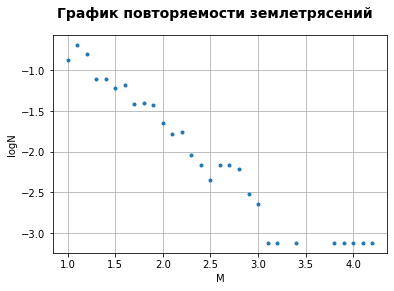

In [35]:
'''Следующий кусок вычисляет необходимые для построения графика повторяемости EQ параметры
а именно: N_tot - суммарное количество землетрясений
a - Series, состоящая из значений lg(N/N_tot) и соотвествующих магнитуд
и, собственно строит график ПЗ для оценки справедливости Г-Р.'''
N_tot = my_cat.shape
f = lambda x: math.log10(x/N_tot[0])
a = my_cat.mag.value_counts().apply(f)
a.plot(style='.')
plt.grid()
plt.xlabel("M")
plt.ylabel("logN")
plt.suptitle('График повторяемости землетрясений', 
             fontsize=14, fontweight='bold')
 # расчет b-value по формуле Aki
# mag - СТОЛБЕЦ С МАГНИТУДОЙ В ДАННОЙ csv


### Необходимо выбрать представительную магнитуду

In [36]:
M_0 = float(input())
b_value = 1 / (my_cat['mag'].mean() - M_0) * (1/ math.log(10))
# расчет b-value по формуле Aki
# mag - СТОЛБЕЦ С МАГНИТУДОЙ В ДАННОЙ csv
print('\033[1m'+'b-value is:', b_value, ' ± ', b_value/math.sqrt(N_tot[0]))

1
b-value is: 1.0371328511877258  ±  0.028513758610411312


# Fractal dimension
#### но, прежде всего, функция вычисления расстояния между землетрясениями


In [37]:
global Pi2, RAD, FLAT
Pi2 = math.pi/2 # тупо пи-на-два
RAD = 0.01745329 # DGR -> RAD
FLAT = 0.993231 # поправка на эллипсоидноть

In [38]:
#@njit
def eq_dist (fi1, la1, fi2, la2, d1, d2): # fi - широта (latitude), la - долгота (longtitude)
    '''Функция позволяет вычислять расстояение между двумя точками земли с учетом сплюсности и глубины'''    
    #if ((fi1-fi2)==0 and (la1-la2)==0): #проверка на расстояние между одним и тем же землетрясением
    #    return (0.0)  
    col1 = Pi2 - math.atan(FLAT * math.tan(fi1 * RAD))
    col2 = Pi2 - math.atan(FLAT * math.tan(fi2 * RAD))
    
    dlon =  la2 * RAD - la1 * RAD
    
    cosdel = math.sin(col1) * math.sin (col2) * math.cos(dlon) + math.cos(col1) * math.cos(col2)
    delr = math.acos(cosdel)
    colat = Pi2 - (fi1 * RAD + fi2 * RAD) / 2.0
    distan_eq =  math.sqrt((delr * 6371.227 * (1.0 + 0.00337853 * (1./3. -((math.cos(colat))*math.cos(colat)))))**2 + (d2-d1)**2)
    if distan_eq == 0:
        distan_eq = 0.01
    return distan_eq

## Непосредственный расчёт фрактальной размерности

In [40]:
'''создание numpy-array для более быстрого обращения [к памяти]
в цикле к соответствующим значениям широты и долготы'''
latitude = my_cat.latitude.to_numpy()
longitude = my_cat.longitude.to_numpy()
depth = my_cat.depth.to_numpy()

In [41]:
'''Вместо того, чтобы каждый раз перебирать для каждого заданного расстояния между
землетрясениями все возможные пары расстояний, в самом начале создается массив
с этими парами. Это существенно сокращает время выполнения программы'''

array_of_dist = [[0] * N_tot[0] for i in range(N_tot[0])]

for i in tqdm(range((N_tot[0]))):
    for j in range(i+1, N_tot[0]):
        #array_of_dist.append(eq_dist(latitude[k], longitude[k], latitude[j], longitude[j], depth[k], depth[j]))
        array_of_dist[i][j] = eq_dist(latitude[i], longitude[i], latitude[j], longitude[j], depth[i], depth[j])
        array_of_dist[j][i] = array_of_dist[i][j]

100%|█████████████████████████████████████| 1323/1323 [00:07<00:00, 182.11it/s]


In [45]:
fractalka = pd.DataFrame(dtype='float')  #ДФ с lg(N/N_0) и lg(A)
X = np.linspace(0.1,2,50) #задает равномерно распределенный массив возможных расстояний м/у ЗТ
element_count = 0
total_pairs = N_tot[0]*(N_tot[0]-1)/2    #общее количество пар землетрясений 
for i in tqdm(X):  
    for n in range(N_tot[0]):
        for m in range(n+1, N_tot[0]):
            if array_of_dist[n][m] < i:
                element_count += 1
    fractalka = pd.concat([fractalka, pd.DataFrame ([math.log10(element_count/total_pairs)],[math.log10(i)])])
    element_count = 0
    #объединение старого массива для расчета FD и новых данных с lg(N/N_0) и lg(A)

100%|██████████████████████████████████████████| 50/50 [00:19<00:00,  2.59it/s]


Text(0, 0.5, 'log(N/N_0)')

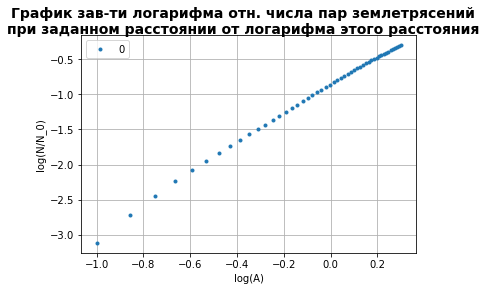

In [46]:
fractalka.plot(style='.')
plt.suptitle('График зав-ти логарифма отн. числа пар землетрясений' '\nпри заданном расстоянии от логарифма этого расстояния', 
             fontsize=14, fontweight='bold')
plt.grid()
plt.xlabel("log(A)")
plt.ylabel("log(N/N_0)")

In [47]:
X = fractalka.index.to_numpy().reshape(-1, 1)
Y = fractalka[0].to_numpy().reshape(-1, 1)
linear_model_d = LinearRegression()
linear_model_d.fit(X, Y)
d_f = linear_model_d.coef_[0][0] # фрактальная размерность
print('\033[1m' + 'Fractal dimension is', d_f)

Fractal dimension is 2.073191337454757


# Функция близости

In [48]:
print("b-value is               ", round(b_value,3))
print("d_f is                   ", round(d_f,3))
print("Minimal magnitude M_0 is ", M_0)

b-value is                1.037
d_f is                    2.073
Minimal magnitude M_0 is  1.0


In [49]:
n_ = [[0] * N_tot[0] for i in range(N_tot[0])]
T_ = [[0] * N_tot[0] for i in range(N_tot[0])]

### Функция для рассчёта времени между зт

In [50]:
import time
import datetime
import copy
t = copy.deepcopy(my_cat.time.to_numpy())
for i in range(len(t)):
    t[i] = t[i].replace('T','')
    t[i] = t[i][:-5]
for i in tqdm(range(N_tot[0]-1,-1,-1)):
    for j in range(i,-1,-1):
        ti_i = time.strptime(t[i], "%Y-%m-%d%H:%M:%S")
        ti_j = time.strptime(t[j], "%Y-%m-%d%H:%M:%S")
        t_i = datetime.datetime(ti_i.tm_year, ti_i.tm_mon, ti_i.tm_mday, ti_i.tm_hour, ti_i.tm_min, ti_i.tm_sec)
        t_j = datetime.datetime(ti_j.tm_year, ti_j.tm_mon, ti_j.tm_mday, ti_j.tm_hour, ti_j.tm_min, ti_j.tm_sec)
        T_[i][j] = (t_j - t_i).total_seconds()
        T_[j][i] = T_[i][j]


100%|██████████████████████████████████████| 1323/1323 [00:45<00:00, 28.94it/s]


In [64]:
for i in tqdm(range(N_tot[0])):
    for j in range(i,N_tot[0]): #ВНИМАНИЕ - ХЗ ПОЧЕМУ ОТ И БЕРУ. ХОЧУ ПРОВЕРИТЬ
        if i == j:
            n_[i][j] = 10000000000
            n_[j][i] = 10000000000
            continue 
        n_[i][j] = T_[i][j]*(array_of_dist[i][j]**d_f)*(10**((-b_value)*my_cat.mag[i]))
        n_[j][i] = n_[i][j]

100%|██████████████████████████████████████| 1323/1323 [00:17<00:00, 76.94it/s]


In [65]:
N = [0] * N_tot[0]
D = [0] * N_tot[0]
for i in range(len(n_)):
    D[i] = round(math.log10((min(n_[i][:]))),1)
    N[i] = n_[:][i].index(min(n_[i][:]))
resultate = pd.DataFrame({'Closest_neigh':D, 'Index_o_CN':N})

In [66]:
Dist_to_Nearest = resultate.Closest_neigh.value_counts(normalize=True)
from pathlib import Path  
filepath = Path('./results/nearest_dist.csv')
Dist_to_Nearest.to_csv(filepath)